DDPG Pendulum-v0 environment

- No batch normalization
- Random Gaussian parameter noise (Not using action noise)

In [1]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import time
import random

In [2]:
class DDPG_Mu(nn.Module):
    def __init__(self):
        super(DDPG_Mu, self).__init__()
        self.fc1 = nn.Linear(3, 512)
        self.fc_mu = nn.Linear(512, 1)
        self.optimizer = optim.Adam(self.parameters(), lr=0.0001)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        mu = torch.tanh(self.fc_mu(x))*2
        return mu
    
    def train(self, loss):
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
class DDPG_Q(nn.Module):
    def __init__(self):
        super(DDPG_Q, self).__init__()
        self.fc_a = nn.Linear(1, 64)
        self.fc_s = nn.Linear(3, 64)
        self.fc_1 = nn.Linear(128, 128)
        self.fc_q = nn.Linear(128, 1)
        self.optimizer = optim.Adam(self.parameters(), lr=0.001)
    
    def forward(self, x, a):
        x1 = F.relu(self.fc_a(a))
        x2 = F.relu(self.fc_s(x))
        x = torch.cat([x1, x2], dim=1)
        x = F.relu(self.fc_1(x))
        q = self.fc_q(x)
        return q

    
    def train(self, loss):
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [3]:
env = gym.make('Pendulum-v0')
Q, Q_p, Mu, Mu_p = DDPG_Q(), DDPG_Q(), DDPG_Mu(), DDPG_Mu()
GAMMA = 0.99
BATCH_SIZE = 32
BUFFER_SIZE = 30000
replay_buffer = []
TAU = 0.01
PARAMETER_NOISE_COEF = 0.0005
EPOCH = 10

In [4]:
def training():
    for i in range(EPOCH):
        s, a, r, s_p, done_mask = make_minibatch()

        target = r + GAMMA*Q_p(s_p, Mu_p(s_p))*done_mask
        critic_loss = F.smooth_l1_loss(Q(s,a), target.detach())
        Q.train(critic_loss)
        
        actor_loss = -Q(s, Mu(s)).mean()
        Mu.train(actor_loss)
        
        soft_target_update(Mu, Mu_p)
        soft_target_update(Q, Q_p)
    
def soft_target_update(model, model_p):
    for param_target, param in zip(model_p.parameters(), model.parameters()):
        param_target.data.copy_(param_target.data*(1.0 - TAU) + param.data*TAU)
        
def init_target_param(model, model_p):
    for param_target, param in zip(model_p.parameters(), model.parameters()):
        param_target.data.copy_(param.data)
        
def parameter_noise(model):
    with torch.no_grad():
        for param in model.parameters():
            param.add_(torch.randn(param.size()) * PARAMETER_NOISE_COEF)
            
def store_transition(s, a, r, s_prime, done):
    if len(replay_buffer) == BUFFER_SIZE:
        del(replay_buffer[0])
    s = s.unsqueeze(0)
    a = a.unsqueeze(0)
    r = torch.tensor([r], dtype=torch.float).unsqueeze(0)
    s_prime = s_prime.unsqueeze(0)
    replay_buffer.append((s, a, r, s_prime, done))
    
def make_minibatch():
    s_list, r_list, a_list, s_p_list, done_list = [], [], [], [], []
    mini_batch = random.sample(replay_buffer, BATCH_SIZE)
    for sample in mini_batch:
        s, a, r, s_p, done = sample
        s_list.append(s)
        a_list.append(a)
        r_list.append(r)
        s_p_list.append(s_p)
        done_list.append([0]) if done else done_list.append([1])
    return torch.cat(s_list, dim=0), torch.cat(a_list, dim=0), torch.cat(r_list, dim=0), torch.cat(s_p_list, dim=0),\
            torch.tensor(done_list, dtype=torch.float).reshape(-1,1)

In [5]:
reward_sum = 0.0
reward_list = []
init_target_param(Mu, Mu_p)
init_target_param(Q, Q_p)

for ep in range(20000):
    observation = env.reset()
    while True:
        state = torch.tensor(observation, dtype=torch.float)
        parameter_noise(Mu) ## for exploration
        action = Mu(state).detach() ## must .detach!! <- important!!!
        observation, reward, done, _ = env.step([action.item()])
        reward_sum += reward
        next_state = torch.tensor(observation, dtype=torch.float)
        store_transition(state, action, (reward+8.1)/8.1, next_state, done)   
        if done:
            break
            
    if len(replay_buffer) >= 500:
        training()
            
    if ep % 20 == 19:
        print('Episode %d'%ep,', Reward mean : %f'%(reward_sum/20.0))
        reward_list.append(reward_sum/20.0)
        #plt.plot(reward_list)
        #plt.show()
        if reward_sum/20.0 > -300: break
        reward_sum = 0.0
        
env.close()

Episode 19 , Reward mean : -1421.412072
Episode 39 , Reward mean : -1634.807661
Episode 59 , Reward mean : -1709.756565
Episode 79 , Reward mean : -1517.216800
Episode 99 , Reward mean : -1353.953250
Episode 119 , Reward mean : -1317.519673
Episode 139 , Reward mean : -1197.931056
Episode 159 , Reward mean : -944.337052
Episode 179 , Reward mean : -847.257661
Episode 199 , Reward mean : -783.865518
Episode 219 , Reward mean : -730.817954
Episode 239 , Reward mean : -818.868928
Episode 259 , Reward mean : -754.295124
Episode 279 , Reward mean : -456.511930
Episode 299 , Reward mean : -359.274235
Episode 319 , Reward mean : -637.836633
Episode 339 , Reward mean : -248.412889


Learning curve

mean reward every 20 episodes

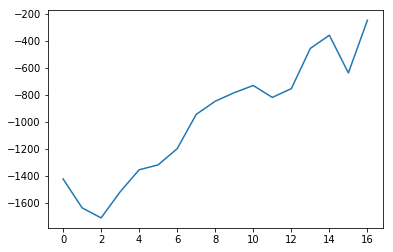

In [6]:
plt.plot(reward_list)
plt.show()

Test rendering

In [8]:
for ep in range(10):
    observation = env.reset()
    while True:
        time.sleep(0.05)
        env.render()

        state = torch.tensor(observation, dtype=torch.float)
        action = Mu(state)
        observation, reward, done, _ = env.step([action.item()])
        if done: break
env.close()

Reference

- https://github.com/seungeunrho/minimalRL/blob/master/ddpg.py
- https://github.com/l5shi/Multi-DDPG-with-parameter-noise/blob/master/Multi_DDPG_with_parameter_noise.ipynb
- https://arxiv.org/abs/1706.01905
- https://openai.com/blog/better-exploration-with-parameter-noise/